In [1]:
#Testing reductions MPI simple version (two reductions)

In [1]:
import logging

import numpy
from mpi4py import MPI 

import astropy.units as u
from astropy.coordinates import SkyCoord

from data_models.polarisation import PolarisationFrame

from processing_library.image.operations import create_empty_image_like
from processing_library.image.operations import create_image_from_array
from processing_components.image.operations import qa_image, show_image, export_image_to_fits
from processing_components.simulation.testing_support import create_test_image
from processing_components.image.gather_scatter import image_gather_facets, image_scatter_facets
from workflows.shared.imaging.imaging_shared import sum_invert_results_local, remove_sumwt
from matplotlib import pyplot as plt
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [2]:
# Define a simple function to take the square root of an image
def imagerooter(image_list) -> list():
    new_image_list = []
    for im in image_list:
        newim = create_empty_image_like(im)
        newim.data = numpy.sqrt(numpy.abs(im.data))
        new_image_list.append(newim)
    return new_image_list


0:before Reduce:    data = 
[[1.]]
Quality assessment:
	Origin: qa_image
	Context: Model image
	Data:
		shape: '(1, 1, 256, 256)'
		max: '1.0064581632614136'
		min: '0.0'
		rms: '0.07250199656841093'
		sum: '1495.430664986372'
		medianabs: '0.0'
		median: '0.0'



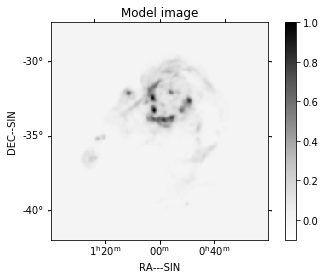

In [3]:
 # Set up MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
    
    #recvdata = numpy.zeros((2,size),dtype='i')
    #recvdata = numpy.zeros((2,size),dtype=numpy.int)
    #senddata = numpy.array([(rank+1)*numpy.arange(size,dtype='i'),(rank+1)*numpy.arange(size,dtype='i')])
    #senddata = numpy.array([(rank+1)*numpy.arange(size,dtype=numpy.int),(rank+1)*numpy.arange(size,dtype=numpy.int)])
    #print('%d:before Reduce:   send data = '%rank)
    #print(senddata)
    #op_sum = MPI.Op.Create(fn_sum, commute=True)
    # I have to create a datatype ???
    #recvdata=comm.reduce(senddata,root=0,op=op_sum)
    #print('%d:after Reduce:    data = '%rank)

    #print(recvdata)



# Create data

frequency = numpy.array([1e8])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
model = create_test_image(frequency=frequency, phasecentre=phasecentre, cellsize=0.001,
                              polarisation_frame=PolarisationFrame('stokesI'))
#print(model)
nchan, npol, ny, nx = model.data.shape
sumwt = numpy.ones([nchan, npol])
print('%d:before Reduce:    data = '%rank)
print(sumwt)



f=show_image(model, title='Model image', cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(model, context='Model image'))
plt.show()



0:after Reduce:    data = 


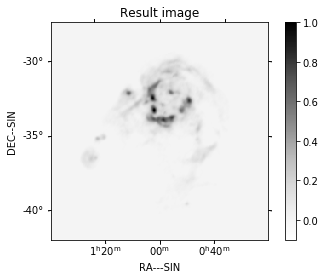

Quality assessment:
	Origin: qa_image
	Context: Result image
	Data:
		shape: '(1, 1, 256, 256)'
		max: '1.0064581632614136'
		min: '0.0'
		rms: '0.07250199656841093'
		sum: '1495.430664986372'
		medianabs: '0.0'
		median: '0.0'



In [4]:
 # Accum images into one with weights 
result_image = create_empty_image_like(model)
comm.Reduce(model.data,result_image.data,root=0,op=MPI.SUM)
if rank==0:
    print('%d:after Reduce:    data = '%rank)
    f=show_image(result_image, title='Result image', cm='Greys', vmax=1.0, vmin=-0.1)
    plt.show()
    print(qa_image(result_image,context='Result image'))
    # test correctness
    assert(result_image.data.shape==model.data.shape)
    numpy.testing.assert_array_almost_equal_nulp(result_image.data,
                                                 (model.data)*size, 7)

In [5]:
result_sumwt = numpy.zeros([nchan, npol])
comm.Reduce(sumwt,result_sumwt,root=0,op=MPI.SUM)
if rank==0:
    print(result_sumwt)
    numpy.testing.assert_array_almost_equal_nulp(result_sumwt,sumwt*size,7)


[[1.]]
